In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import skew, kurtosis

In [2]:
sns.set(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False

# EDA 分析

## **加载数据**

In [3]:
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")['label']

In [4]:
y.head()

0    10
1     5
2     5
3     5
4     5
Name: label, dtype: int64

In [5]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.617940,-0.39198,0.13278,0.032551,0.55201,0.83393,-0.837550,-0.87406,0.43930,0.26826,...,-0.45454,0.36452,1.57530,-0.620320,-0.25371,-0.44775,-0.038273,-0.019938,-0.195500,0.428830
1,0.333860,-1.54910,1.67050,0.793560,0.80251,-0.07206,-0.068276,3.30240,0.52045,0.68572,...,-0.36913,1.74080,1.28660,-0.013396,-1.53930,0.83354,0.472610,0.513030,-0.743140,1.219900
2,0.040399,-0.60807,1.62080,-0.355970,0.12105,1.35250,0.373200,1.11170,0.35894,-0.34410,...,-1.40230,-0.24763,0.50705,0.708220,-0.60083,0.91104,0.009979,-0.475990,-0.094731,-0.008521
3,1.723600,0.19529,1.03880,-3.009100,-0.33222,0.91067,0.666690,0.71725,3.05850,1.48990,...,-1.21540,-0.25284,-1.30780,-0.445660,0.27918,0.26467,-0.149360,1.492900,-1.176700,-1.854500
4,-1.032300,1.90010,-1.46010,0.383710,-0.51039,0.74481,-0.914660,-0.86588,-0.34426,0.86965,...,1.32230,0.06020,-1.07900,-0.617050,1.18450,-0.21063,-0.105870,-0.412040,1.409700,0.133350


## **观测基本的数据结构，查看有无缺失值**

In [6]:
print(f"The size of data is {X.shape[0]}")
print(f"The number of features of each sample is {X.shape[1]}")

The size of data is 10000
The number of features of each sample is 300


In [7]:
X.isnull().values.any()

False

- 上述的结果说明输入有10000个样本，每个样本有300个特征
- 并没有空值，可以不做缺失值处理

## **特征值范围分析**

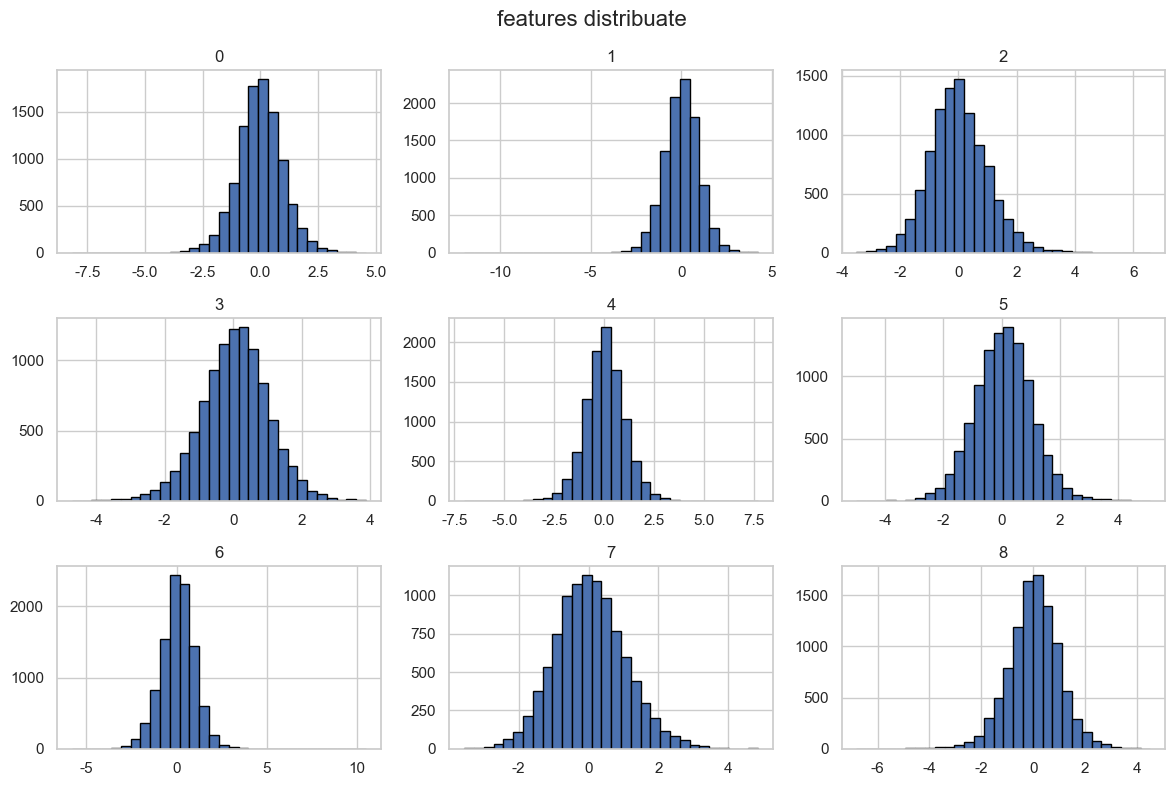

In [8]:
X.iloc[:, :9].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("features distribuate", fontsize=16)
plt.tight_layout()
plt.show()

### 这里先观察了前十个特征的分布情况，特征值主要分布在0左右，进一步对每一个特征的均值，标准差，偏度，峰度进行提取，之后观察详细的统计量分布情况

In [9]:
feature_stats = pd.DataFrame({
    "Mean": X.mean(), ## 均值
    "Std": X.std(), ## 标准差
    "Skewness": X.skew(), ## 偏度
    "Kurtosis": X.kurtosis() ## 峰度
})
feature_stats.head()

,Mean,Std,Skewness,Kurtosis
0,-0.021449,0.986789,-0.061139,1.277416
1,-0.000912,1.008141,-1.245544,12.821160
2,0.012368,1.009709,0.421092,1.126348
3,0.045447,0.985909,-0.146856,0.628243
4,0.034961,0.988168,0.042204,1.413371


### 均值分布
- 反映特征数据的中心位置
- 取值区间为[-0.1， 0.1]
- 极少数特征存在偏移量过大的情况（暂时忽略）

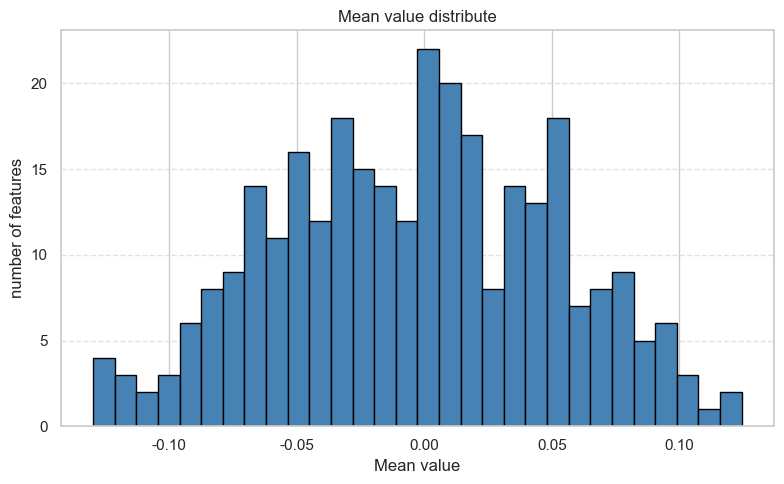

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(feature_stats["Mean"], bins=30, color="steelblue", edgecolor="black")
plt.title("Mean value distribute")
plt.xlabel("Mean value")
plt.ylabel("number of features")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 标准差分布
- 衡量特征数据的波动程度
- 大部分数据特征分布较为稳定，区间在[0.96, 1.04]
- 可能已经完成了归一化？无需处理？

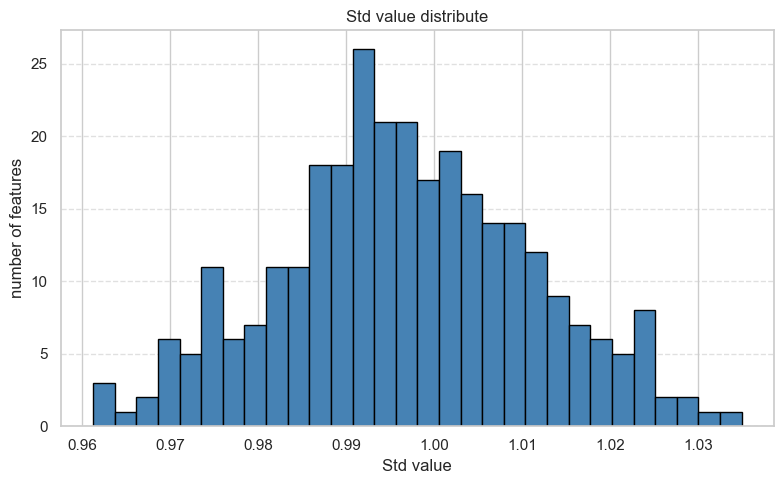

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(feature_stats["Std"], bins=30, color="steelblue", edgecolor="black")
plt.title("Std value distribute")
plt.xlabel("Std value")
plt.ylabel("number of features")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 偏度
- 衡量数据的偏斜方向和程度（>0右偏，<0左偏）
- 大部分特征的偏度为0左右，说明每个特征的分布近似于正态分布
- 大部分特征分布良好

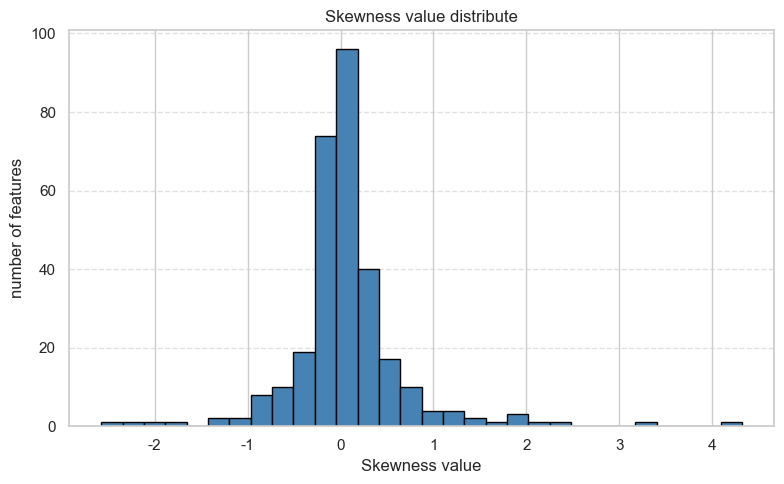

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(feature_stats["Skewness"], bins=30, color="steelblue", edgecolor="black")
plt.title("Skewness value distribute")
plt.xlabel("Skewness value")
plt.ylabel("number of features")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 峰度分布
- 衡量数据分布的尖峭程度（>3 为尖峰，<3 为扁平，=3 为正态）
- 峰度集中于 0 ~ 10，但部分特征高达 70（极高峰度），表示尖峰分布
- 极高峰度的特征可能含有异常值，最好还是进行标准化或归一化处理

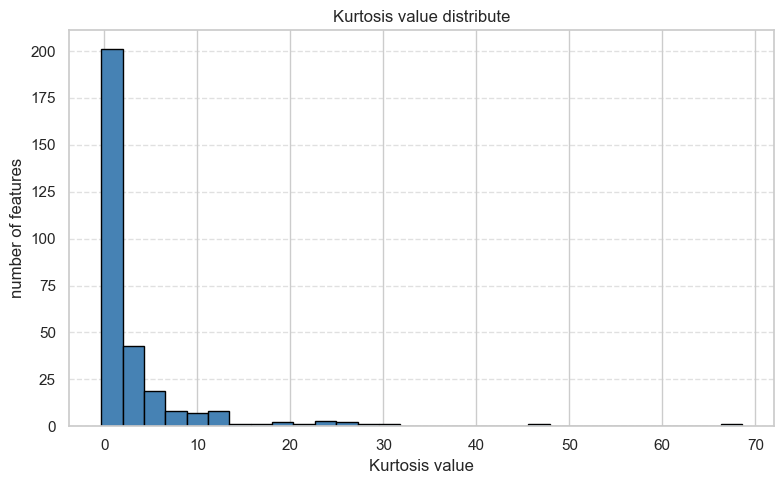

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(feature_stats["Kurtosis"], bins=30, color="steelblue", edgecolor="black")
plt.title("Kurtosis value distribute")
plt.xlabel("Kurtosis value")
plt.ylabel("number of features")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **类别分布**
- 存在严重的类别不均衡问题，需要进行类别不均衡处理
- 5，10，12，6，8，17类的样本数量较多

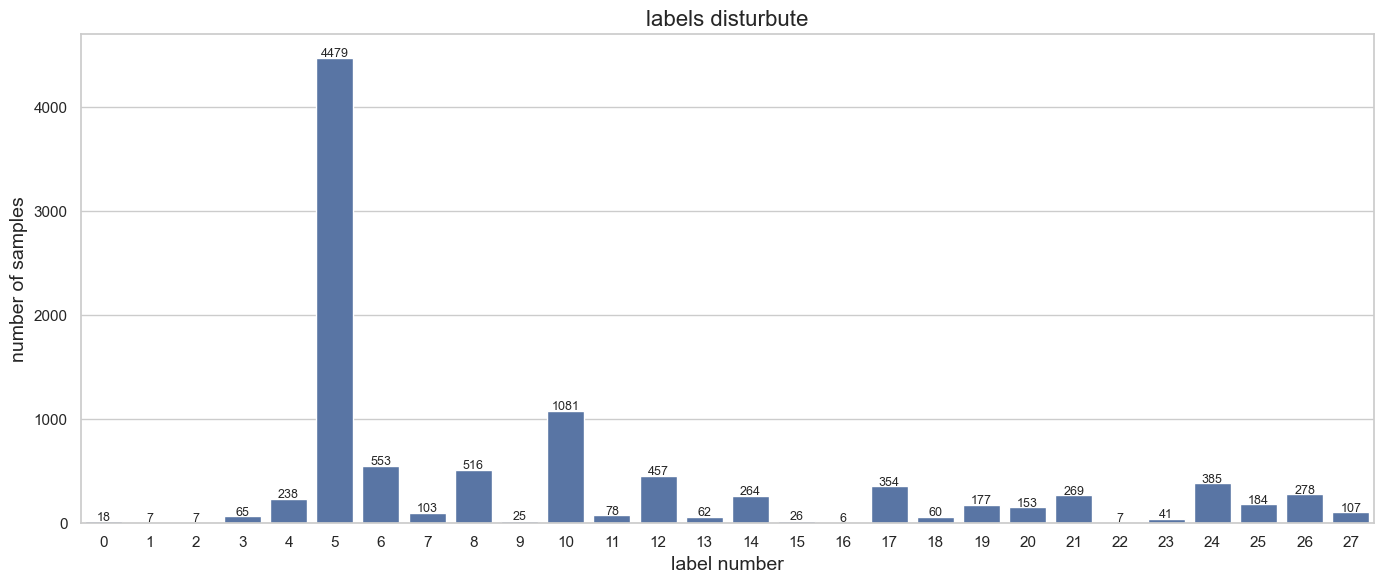

In [14]:
label_counts = y.value_counts().sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("labels disturbute", fontsize=16)
plt.xlabel("label number", fontsize=14)
plt.ylabel("number of samples", fontsize=14)
plt.xticks(rotation=0)
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 5, str(count), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

## **特征值标准化**

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **特征值提取**

### 关于特征值提取，考虑采用集成方法的模式进行
- 好处是结合不同模型的优点
- Filter-based：单独评估每个特征和目标变量的统计相关性， 速度快，实现简单，但是容易遗漏组合特征，产生一个score分数（F-score，MI）
- Embedded：嵌入式方法，利用模型本身学习那些特征比较重要，在训练过程中赋予每个特征的权重，产生一个importance分数（RF Importance）
- Wrapper-based：采用交叉验证的方式，在不同的特征子集上运行，当下最为严谨的方式，产生一个ranking，排名重要性（RFECV）
- 结合三种模型的分数取合，最后统一排名，需要注意的是，如何该特征通过了wrapper的检测，证明了是重要特征，则额外的加100分（可以当作一种阈值）

### 获取特征名字

In [16]:
feature_names = [f"F{i}" for i in range(X.shape[1])]
feature_names[0]

'F0'

### 使用Filter-based的方法评估特征

In [17]:
f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X_scaled, y)
f_scores = f_selector.scores_
f_scores  ## 单变量方差分析得分

array([ 25.39182202,  13.9236844 ,  23.56572351,  25.71057111,
        43.42702999, 145.79132486,  83.11047384,  89.84919484,
        32.33733365,  93.07339618, 135.23260652,  11.40204599,
        21.51775617,  20.55499211, 119.28544194,  35.31069195,
        45.81187597, 287.1221397 ,   5.88512475,  63.3595282 ,
        99.53148909,  72.49273278,  28.50385729,  26.42150263,
       115.79393078,  42.03980058, 166.84478262, 131.11279596,
        82.21514765,  38.46902347,  25.96674737,  34.32318485,
        20.33918483,  45.22715373,  66.68008597,  40.91317006,
        52.37401273,  19.16605728, 116.44172536,  61.11272027,
        14.58764414, 144.80833585,  14.37752351,  58.28198768,
        43.7295075 ,  28.52639026, 188.12540674, 128.59778901,
       316.40638607,  95.05598277,  45.04503056,  75.5027578 ,
        31.48944451,  51.22245621,  45.30342319,  71.97538963,
        36.22865536,  14.64155902,  16.22262186, 109.29313226,
        33.97734752,  94.54294092,  75.30140975, 137.44

In [18]:
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
mi_scores ## 与label的互信息分析得分

array([0.0392074 , 0.0127247 , 0.02310086, 0.05055211, 0.0642427 ,
       0.17565892, 0.11884568, 0.13065557, 0.047028  , 0.15891721,
       0.15219743, 0.01159797, 0.03053544, 0.02952751, 0.14689052,
       0.05604785, 0.06627461, 0.30154692, 0.00750933, 0.08980998,
       0.13230256, 0.10832572, 0.03754503, 0.04842968, 0.14496355,
       0.05239234, 0.21088341, 0.16955007, 0.11763663, 0.05882469,
       0.0408744 , 0.05950474, 0.02918288, 0.07101424, 0.09928671,
       0.05727144, 0.07331131, 0.01845008, 0.14127029, 0.08444404,
       0.02310746, 0.17258477, 0.04254909, 0.0838917 , 0.05653863,
       0.04870179, 0.21131376, 0.16229893, 0.31819298, 0.14314697,
       0.06054609, 0.09844676, 0.07131262, 0.06867694, 0.06267193,
       0.10137941, 0.07089663, 0.02866935, 0.02622653, 0.14746345,
       0.03843475, 0.11151708, 0.08489557, 0.17641242, 0.09779494,
       0.05612788, 0.03442493, 0.0452216 , 0.03551947, 0.10057232,
       0.06842592, 0.23881502, 0.07877019, 0.08822568, 0.02786

### 使用嵌入式的方法评估，使用随机森林模型为每个特征产生重要性分数

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)
rf_importance = rf_model.feature_importances_
rf_importance

array([0.00194223, 0.00196116, 0.00172221, 0.00212356, 0.00259889,
       0.00388081, 0.00248599, 0.00487831, 0.00234778, 0.00672394,
       0.00737764, 0.00181017, 0.00199054, 0.00182277, 0.00324188,
       0.002308  , 0.00262019, 0.00772391, 0.00170055, 0.0021151 ,
       0.00301371, 0.00267022, 0.00248374, 0.00205266, 0.0034538 ,
       0.00221279, 0.00570614, 0.0044796 , 0.00546873, 0.00219206,
       0.00234312, 0.00216922, 0.00211114, 0.00256602, 0.00355676,
       0.00233091, 0.00234109, 0.00233751, 0.00483458, 0.00248246,
       0.00212321, 0.0061442 , 0.00195276, 0.00405512, 0.00220312,
       0.00187619, 0.00845803, 0.00319831, 0.02610028, 0.00480599,
       0.00307384, 0.00189757, 0.00194809, 0.00298993, 0.00217856,
       0.00380122, 0.00229344, 0.00195529, 0.00172464, 0.00388958,
       0.00195876, 0.00350699, 0.0028418 , 0.00858924, 0.00398904,
       0.00202246, 0.00208818, 0.00187583, 0.00208252, 0.00423684,
       0.00259263, 0.0106516 , 0.00206785, 0.00283751, 0.00170

### 使用wrapper方法对每个特征进行分数的评估

In [24]:
xgb_model = XGBClassifier(tree_method='hist',device='cuda', use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_scaled, y)
xgb_importance = xgb_model.feature_importances_

D:\Anaconda3\envs\skin_lesion_class\lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
xgb_importance

array([0.00141686, 0.001511  , 0.00210367, 0.00126227, 0.00117908,
       0.00216762, 0.0016959 , 0.00101789, 0.00277841, 0.00352861,
       0.00289511, 0.00105689, 0.00130756, 0.00123063, 0.00115454,
       0.00127133, 0.00379026, 0.00956889, 0.001125  , 0.0015924 ,
       0.00299517, 0.001834  , 0.00172141, 0.00197573, 0.00314941,
       0.00220448, 0.00350455, 0.00169073, 0.00538546, 0.00143318,
       0.00211099, 0.00130006, 0.00130721, 0.00193341, 0.00158895,
       0.00166283, 0.002863  , 0.00250594, 0.00147713, 0.00217644,
       0.00117035, 0.00609753, 0.00097939, 0.00305544, 0.00166431,
       0.00131049, 0.00192225, 0.00254041, 0.13905162, 0.00165121,
       0.0039705 , 0.00280928, 0.00101134, 0.00214943, 0.00205387,
       0.00383607, 0.00132647, 0.00119044, 0.00094429, 0.00368242,
       0.00141617, 0.00711733, 0.0011435 , 0.00163842, 0.0057286 ,
       0.00174799, 0.00153893, 0.00157282, 0.00148072, 0.00292409,
       0.00238384, 0.00749886, 0.00134466, 0.00122202, 0.00151

### 集成所有的评分

In [30]:
summary_df = pd.DataFrame({
    "Feature": feature_names,
    "F_score": f_scores,
    "MI_score": mi_scores,
    "RF_importance": rf_importance,
    "XGB_importance": xgb_importance
})
summary_df.head()

,Feature,F_score,MI_score,RF_importance,XGB_importance
0,F0,25.391822,0.039207,0.001942,0.001417
1,F1,13.923684,0.012725,0.001961,0.001511
2,F2,23.565724,0.023101,0.001722,0.002104
3,F3,25.710571,0.050552,0.002124,0.001262
4,F4,43.427030,0.064243,0.002599,0.001179


### 用rank方法进行量化，确保三种方法的特征评分保持在同一个量级

In [31]:
summary_df["Votes"] = (
    summary_df["F_score"].rank(ascending=False) +
    summary_df["MI_score"].rank(ascending=False) +
    summary_df["RF_importance"].rank(ascending=False) +
    summary_df["XGB_importance"].rank(ascending=False)
)

In [32]:
summary_df.head()

,Feature,F_score,MI_score,RF_importance,XGB_importance,Votes
0,F0,25.391822,0.039207,0.001942,0.001417,983.0
1,F1,13.923684,0.012725,0.001961,0.001511,1058.0
2,F2,23.565724,0.023101,0.001722,0.002104,972.0
3,F3,25.710571,0.050552,0.002124,0.001262,916.0
4,F4,43.427030,0.064243,0.002599,0.001179,733.0


### 选出排名前50的特征值

In [59]:
summary_df_sorted = summary_df.sort_values(by="Votes", ascending=False).reset_index(drop=True)
top_k = 50  
top_features = summary_df_sorted.head(top_k)

In [60]:
top_features

,Feature,F_score,MI_score,RF_importance,XGB_importance,Votes
0,F203,10.792686,0.011141,0.001729,0.000661,1193.0
1,F18,5.885125,0.007509,0.001701,0.001125,1174.0
2,F11,11.402046,0.011598,0.001810,0.001057,1160.0
3,F58,16.222622,0.026227,0.001725,0.000944,1150.0
4,F180,13.661029,0.019007,0.001791,0.001076,1147.0
5,F137,14.685273,0.028759,0.001816,0.000698,1140.0
6,F191,12.131297,0.026949,0.001766,0.001132,1136.0
7,F273,14.226373,0.014478,0.001775,0.001223,1130.0
8,F275,16.768866,0.018386,0.001773,0.001166,1127.0
9,F192,16.912201,0.038510,0.001711,0.000948,1112.0


## **处理类别分布不均衡的问题**

In [61]:
selected_columns = top_features["Feature"]
X_selected = pd.DataFrame(X_scaled, columns=feature_names)[selected_columns]
y_array = y.values.ravel()

In [62]:
y_array

array([10,  5,  5, ..., 17, 24,  5], dtype=int64)

In [63]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X_selected, y_array)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2588\709443467.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis", edgecolor="black")


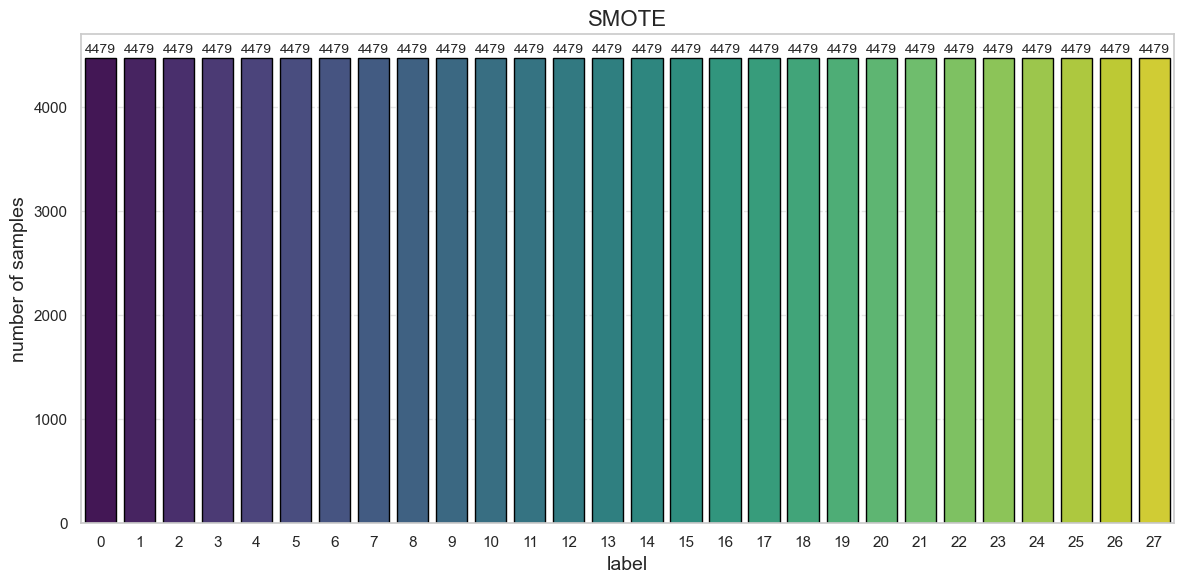

In [64]:
# 统计 label 分布
label_counts = Counter(y_balanced)
labels = sorted(label_counts.keys())
counts = [label_counts[label] for label in labels]

# 可视化
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=counts, palette="viridis", edgecolor="black")

# 图形美化
plt.title("SMOTE", fontsize=16)
plt.xlabel("label", fontsize=14)
plt.ylabel("number of samples", fontsize=14)
plt.xticks(rotation=0)
for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## **对于特征值选取选出的top50的特征进行特征值的统计量分析**

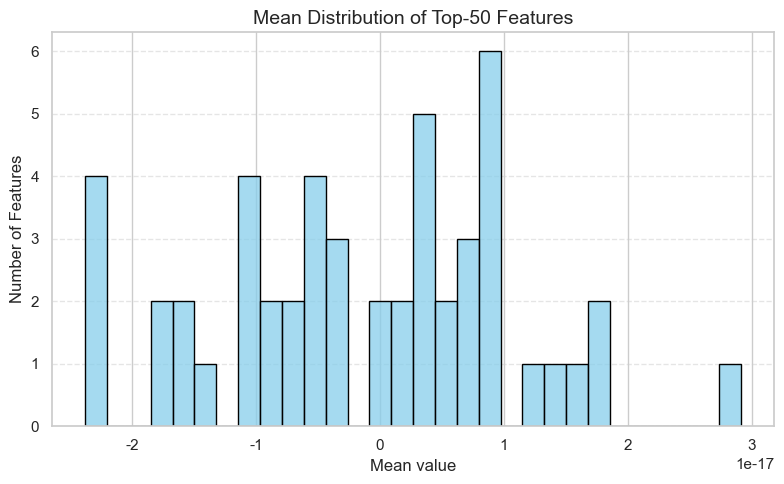

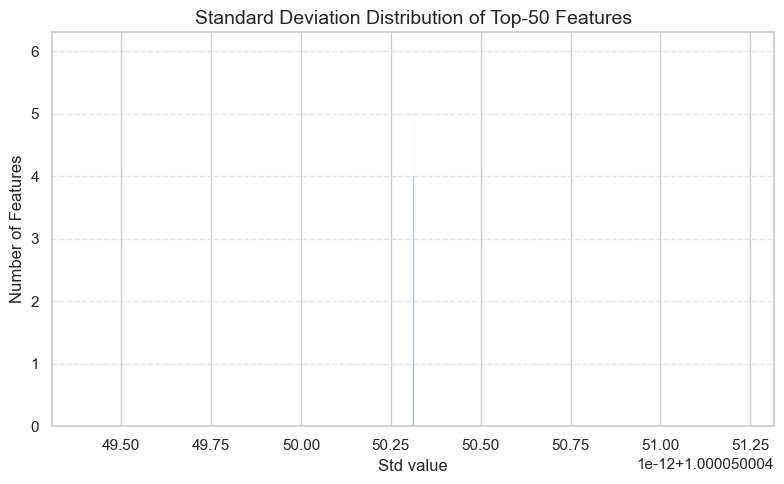

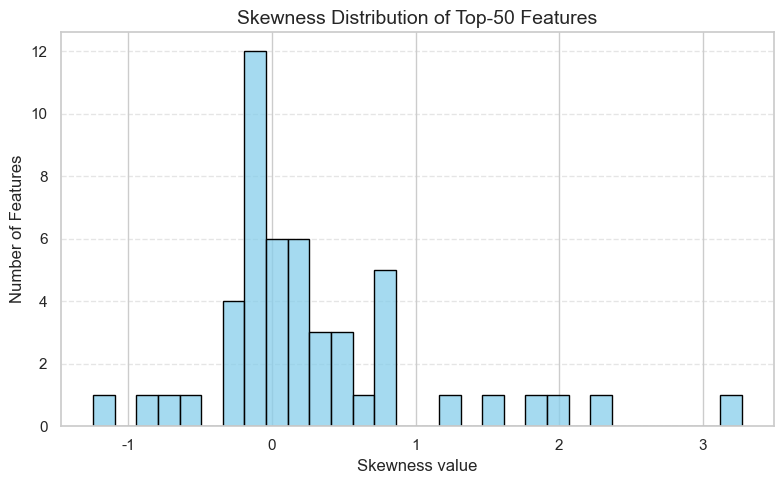

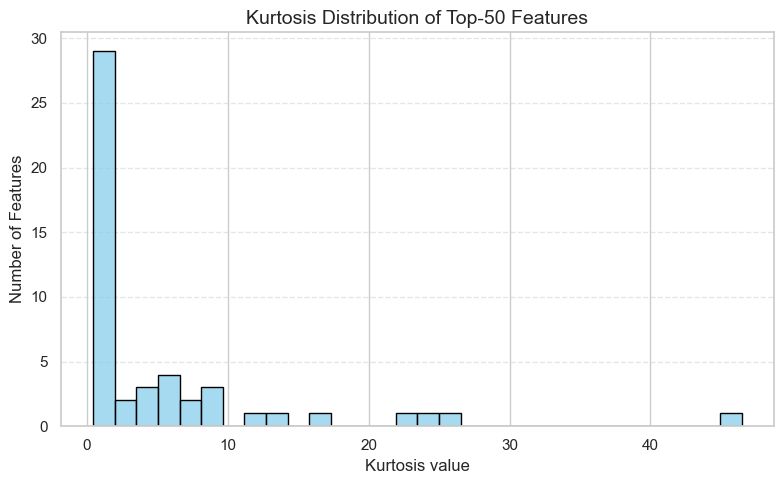

In [65]:
# Step 1: 选取 Top-K 特征对应的数据
selected_columns = top_features["Feature"].values
X_top = pd.DataFrame(X_scaled, columns=feature_names)[selected_columns]

# Step 2: 计算四种统计量
mean_values = X_top.mean(axis=0)
std_values = X_top.std(axis=0)
skew_values = X_top.skew(axis=0)
kurtosis_values = X_top.kurtosis(axis=0)

# Step 3: 绘制直方图函数（复用）
def plot_stat_hist(values, title, xlabel):
    plt.figure(figsize=(8, 5))
    sns.histplot(values, bins=30, kde=False, edgecolor='black', color='skyblue')
    plt.title(f"{title} Distribution of Top-{len(X_top.columns)} Features", fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Features")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Step 4: 依次画图
plot_stat_hist(mean_values, "Mean", "Mean value")
plot_stat_hist(std_values, "Standard Deviation", "Std value")
plot_stat_hist(skew_values, "Skewness", "Skewness value")
plot_stat_hist(kurtosis_values, "Kurtosis", "Kurtosis value")

## **使用选出的50个特征和均衡类别之后的data和label进行模型训练**

In [72]:
#划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

#构造 XGBoost
xgb_model = XGBClassifier(
    tree_method='hist',
    device='cuda',         
    eval_metric='mlogloss', 
    random_state=42
)

# 模型训练
xgb_model.fit(X_train, y_train)

# 模型预测
y_pred = xgb_model.predict(X_test)

### 绘制混淆矩阵

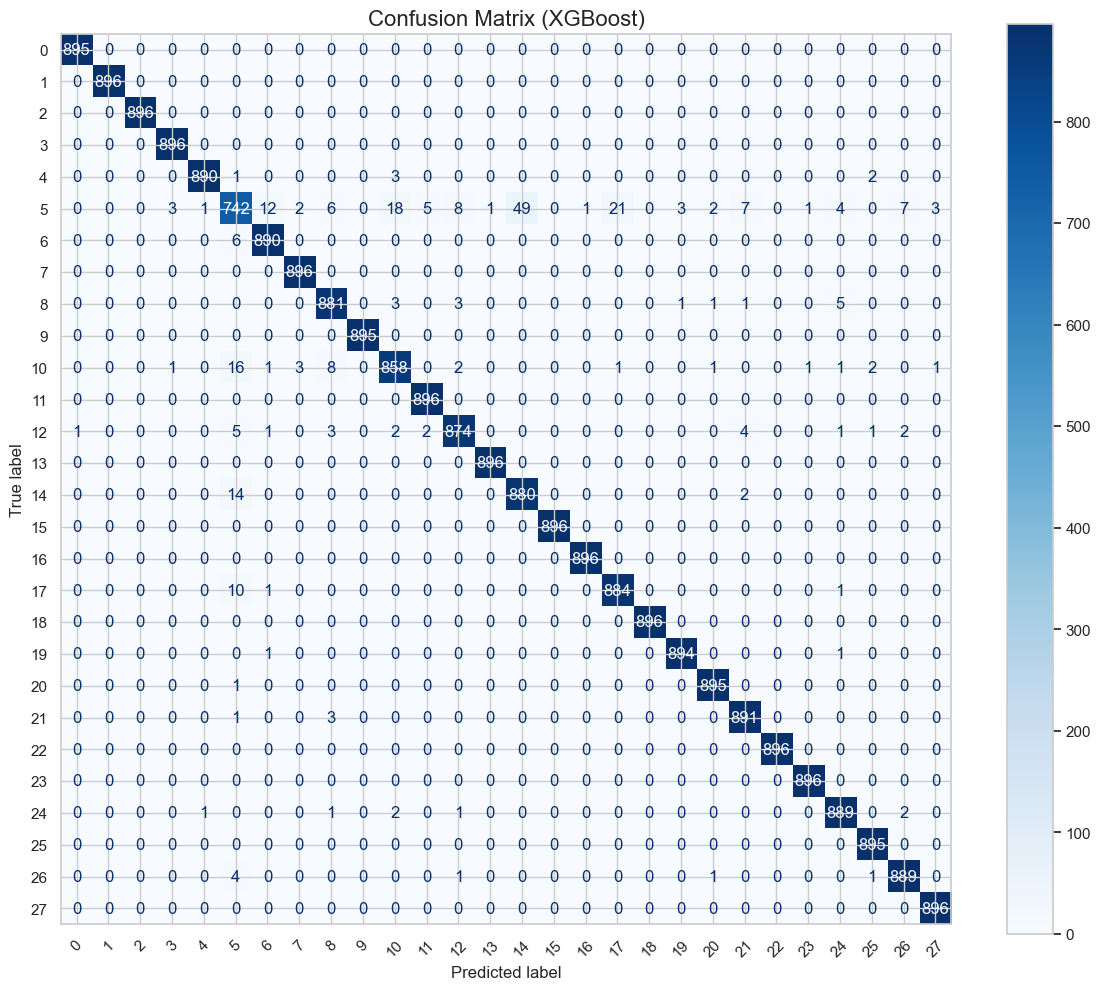

In [78]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(12, 10))  
disp.plot(
    cmap="Blues",
    ax=ax,
    xticks_rotation=45,
    colorbar=True
)

plt.title("Confusion Matrix (XGBoost)", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()
plt.show()

### 评估模型

In [75]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.9882679393693969

In [76]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_weighted

0.9882669313443337

## **为什么不使用accuracy作为评价指标**

# 为什么不使用 Accuracy 作为评价指标

在类别分布不均衡的多分类任务中，准确率（Accuracy）往往不能真实反映模型性能。因此，我们推荐使用更鲁棒且具有代表性的指标：

- Macro F1-score
- Weighted F1-score

以下将通过数学公式、定义及案例进行详细分析说明。

---

## 一、三种指标的定义与数学公式

### 1. Accuracy（准确率）

定义：预测正确的样本数占总样本数的比例。

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

在多分类任务中，Accuracy 也可以表达为：

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(y_i = \hat{y}_i)
$$

其中：

- $y_i$：第 $i$ 个样本的真实标签  
- $\hat{y}_i$：模型预测的标签  
- $\mathbf{1}(\cdot)$：指示函数，若预测正确为 1，否则为 0

缺点：Accuracy 只关注预测正确总数，不能反映每个类别的分类质量。

---

### 2. F1-score（单类）

定义：F1 是精确率（Precision）与召回率（Recall）的调和平均数：

$$
F1_i = 2 \cdot \frac{P_i \cdot R_i}{P_i + R_i}
$$

其中：

- $P_i = \frac{TP_i}{TP_i + FP_i}$：第 $i$ 类的精确率  
- $R_i = \frac{TP_i}{TP_i + FN_i}$：第 $i$ 类的召回率  

F1-score 综合考虑了预测的准确性与覆盖能力，对不均衡数据更敏感。

---

### 3. Macro F1-score（宏平均 F1）

定义：对所有类别的 F1-score 取算术平均，不考虑每类样本数量：

$$
\text{Macro F1} = \frac{1}{K} \sum_{i=1}^{K} F1_i
$$

特点：

- 每个类别贡献相等权重  
- 更能反映模型在少数类上的性能表现

---

### 4. Weighted F1-score（加权平均 F1）

定义：按每类样本数权重，对 F1-score 进行加权平均：

$$
\text{Weighted F1} = \sum_{i=1}^{K} \frac{n_i}{n} \cdot F1_i
$$

其中：

- $n_i$：第 $i$ 类样本数  
- $n$：总样本数

Weighted F1 更能代表整体表现，兼顾类别不均衡。

---

## 二、Accuracy 的失效示例（为什么它会误导）

假设数据如下：

- 类别 0：9500 个样本  
- 类别 1：500 个样本  
- 总样本数：10,000  
- 模型始终预测为类别 0

Accuracy：

$$
\frac{9500}{10000} = 95\%
$$

虽然数值很高，但模型完全不会识别类别 1，性能严重失衡。

Macro F1：

- $F1_0 = 0.974$, $F1_1 = 0.000$
- $\text{Macro F1} = \frac{0.974 + 0.000}{2} = 0.487$

揭示模型对类别 1 分类性能非常差。

Weighted F1：

$$
\text{Weighted F1} = \frac{9500 \cdot 0.974 + 500 \cdot 0.000}{10000} = 0.9215
$$

比 Accuracy 更真实反映模型性能，少数类得分为 0 也有惩罚。

---

## 三、三者对比总结

| 指标类型         | 是否考虑类别分布 | 是否关注少数类表现 | 是否适合不均衡分类 | 推荐程度 |
|------------------|------------------|----------------------|---------------------|-----------|
| Accuracy          | 是               | 否                   | 否                  | 不推荐     |
| Macro F1-score    | 否（等权）       | 是                   | 是                  | 推荐       |
| Weighted F1-score | 是（加权）       | 是                   | 是                  | 推荐       |

---

## 结论建议

在类别分布不均衡的多分类任务中：

- Accuracy 容易被多数类主导，不能真实评估模型性能
- Macro F1-score 更关注模型在所有类别上的公平性
- Weighted F1-score 综合了类别比例，反映整体分类质量

因此，我们推荐使用：

**Macro F1-score + Weighted F1-score** 作为模型评估的核心指标。
